In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import tensorflow as tf
import keras_preprocessing
from keras_preprocessing import image
from keras_preprocessing.image import ImageDataGenerator
from tensorflow import keras
from tensorflow.keras.applications import EfficientNetB4
from tensorflow.keras import layers, optimizers
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from keras import Model
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current sessionl

## Visualize data

In [ ]:
img = mpimg.imread('/kaggle/input/plant-pathology-2021-fgvc8/train_images/93e896990cb365b5.jpg')
plt.imshow(img)
print(img.shape)

In [ ]:
df = pd.read_csv('/kaggle/input/plant-pathology-2021-fgvc8/train.csv')
df.head()

In [ ]:
df.count()

In [ ]:
train_images_path = '/kaggle/input/plant-pathology-2021-fgvc8/train_images/'
for i in range(1, 6):
    img = mpimg.imread(train_images_path + df.iloc[i].image)
    plt.imshow(img)
    plt.axis('Off')
    plt.show()

## Prepare data to process

### Transform labels

Text(0.5, 1.0, 'Labels counts')

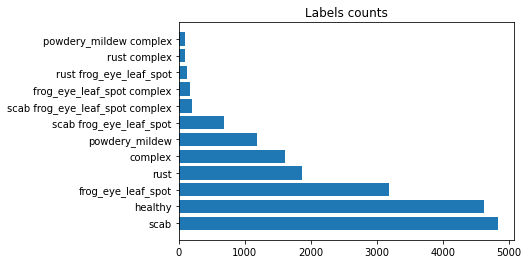

In [7]:
df = pd.read_csv('/kaggle/input/plant-pathology-2021-fgvc8/train.csv')
labels_counts = df["labels"].value_counts()

plt.barh(labels_counts.index,labels_counts)
plt.title("Labels counts")

In [8]:
df['labels'] = [x.split(' ') for x in df['labels']]
labels = df['labels']
labels = [x for label in labels for x in label]
classes = np.unique(labels)

labelizer = MultiLabelBinarizer(classes=classes)
labelizer.fit(df.labels.values)

labels = labelizer.transform(df.labels.values)

labels_df = pd.DataFrame(columns=classes, data=labels, index=df.index)

labels_df.head()

,complex,frog_eye_leaf_spot,healthy,powdery_mildew,rust,scab
0,0,0,1,0,0,0
1,1,1,0,0,0,1
2,0,0,0,0,0,1
3,0,0,0,0,0,1
4,1,0,0,0,0,0


In [9]:
df.reset_index(drop=True, inplace=True)
labels_df.reset_index(drop=True, inplace=True)
results = pd.concat([df['image'], labels_df], axis=1)
results.head(20)

,image,complex,frog_eye_leaf_spot,healthy,powdery_mildew,rust,scab
0,800113bb65efe69e.jpg,0,0,1,0,0,0
1,8002cb321f8bfcdf.jpg,1,1,0,0,0,1
2,80070f7fb5e2ccaa.jpg,0,0,0,0,0,1
3,80077517781fb94f.jpg,0,0,0,0,0,1
4,800cbf0ff87721f8.jpg,1,0,0,0,0,0
5,800edef467d27c15.jpg,0,0,1,0,0,0
6,800f85dc5f407aef.jpg,0,0,0,0,1,0
7,801d6dcd96e48ebc.jpg,0,0,1,0,0,0
8,801f78399a44e7af.jpg,1,0,0,0,0,0
9,8021b94d437eb7d3.jpg,0,0,1,0,0,0


In [ ]:
# labels_onehot = pd.Series(list([item[1].to_numpy() for item in results[list(results.keys()[2:-1])].iterrows()]))
# results['labels_onehot'] = labels_onehot
# #print(labels_onehot)
# results.head()

In [ ]:
# pd.Series([item[1].to_numpy() for item in results[list(results.keys()[2:-1])].iterrows()])

In [10]:
X_train, X_test, y_train, y_test = train_test_split(results['image'], results[['complex','frog_eye_leaf_spot','healthy','powdery_mildew','rust', 'scab']], test_size=0.2, random_state=12, 
                                                    stratify=df['labels']) # each sample contain the same amount per class

data_training = results.iloc[y_train.index]
print(data_training.shape)

data_validation = results.iloc[y_test.index]
print(data_validation.shape)
data_training.head()

(14905, 7)
(3727, 7)


,image,complex,frog_eye_leaf_spot,healthy,powdery_mildew,rust,scab
12983,dad170c986ecc23d.jpg,0,0,1,0,0,0
12166,d4df2f93901b1f20.jpg,0,0,0,0,0,1
17830,fc3b85b384eb0985.jpg,0,0,1,0,0,0
16364,f2e5ce3cc9a424aa.jpg,0,0,0,1,0,0
11840,d2921f2eeee4ca88.jpg,0,1,0,0,0,0


In [11]:
batch_size = 16
seed = 88
train_images_path = '/kaggle/input/plant-pathology-2021-fgvc8/train_images/'
train_datagen = ImageDataGenerator(
        rescale = 1/255.,
        rotation_range = 15,
        width_shift_range=0.2, 
        height_shift_range=0.2,
        zoom_range = 0.2,
        shear_range=0.3,
        featurewise_center=False,
        featurewise_std_normalization=False,
        horizontal_flip=True,
        vertical_flip=True,
        validation_split= 0.2)
traing_generator = train_datagen.flow_from_dataframe(
                    data_training, 
                    directory=train_images_path,
                    x_col='image',
                    y_col=data_training.columns.tolist()[1:],
                    subset = "training",
                    class_mode='raw',
                    batch_size=batch_size,
                    target_size=(300, 300),
                    color_mode='rgb',
                    shuffle=True, 
                    seed = seed)

valid_datagen = ImageDataGenerator(rescale = 1./255.)
valid_generator = train_datagen.flow_from_dataframe(
                    data_validation, 
                    directory=train_images_path,
                    x_col='image',
                    y_col=data_validation.columns.tolist()[1:],
                    subset = "validation",
                    class_mode='raw',
                    batch_size=batch_size,
                    target_size=(300, 300),
                    color_mode='rgb',
                    shuffle=True,
                    seed = seed)

Found 11924 validated image filenames.
Found 745 validated image filenames.


### Using tf.data

In [ ]:
# def process_img(file_path, label):
#     #print(file_path, label)
#     #img = image.load_img(file_path, target_size=(300, 300))
#     image = tf.io.read_file(file_path)
#     image = tf.image.decode_jpeg(image, channels=3)
#     image = tf.image.convert_image_dtype(image, tf.float32)
    
#     image = tf.image.resize(image, [300, 300])
    
#     return image, label

In [ ]:
# train_images_path = '/kaggle/input/plant-pathology-2021-fgvc8/train_images/'
# df = pd.read_csv('/kaggle/input/plant-pathology-2021-fgvc8/train.csv')

# #df['path'] = train_images_path + df['image']

# X_train, X_test, y_train, y_test = train_test_split(df['image'], df['labels'], test_size=0.2, random_state=12, 
#                                                     stratify=df['labels']) # each sample contain the same amount per class


# data_sample = df.iloc[y_train.index]
# print(data_sample.shape)
# data_sample.head()

In [ ]:
# labels_counts = data_sample["labels"].value_counts()

# plt.barh(labels_counts.index,labels_counts)
# plt.title("Labels counts")

In [ ]:
# tmp = [x.split(' ') for x in df['labels']]
# labels = tmp
# labels = [x for label in labels for x in label]
# classes = np.unique(labels)

# labelizer = MultiLabelBinarizer(classes=classes)
# labelizer.fit(tmp)

# labels = labelizer.transform(tmp)

# labels_df = pd.DataFrame(columns=classes, data=labels, index=df.index)

# labels_df.head()
# df.reset_index(drop=True, inplace=True)
# labels_df.reset_index(drop=True, inplace=True)
# results = pd.concat([df, labels_df], axis=1)
# results.head(20)

In [ ]:
#data_sample["path"] = train_images_path + data_sample["image"]

# AUTO = tf.data.experimental.AUTOTUNE
# train_ds = pd.concat([X_train, y_train], axis=1)
# valid_ds = pd.concat([X_test, y_test], axis=1)

# files_path = list(train_ds['path'])
# labels_onehot = [item[1].to_numpy() for item in train_ds[list(train_ds.keys()[3:])].iterrows()]

# train_ds = tf.data.Dataset.from_tensor_slices((files_path, labels_onehot))
# train_ds = train_ds.map(process_img, num_parallel_calls=AUTO)

# files_path = list(valid_ds['path'])
# labels_onehot = [item[1].to_numpy() for item in valid_ds[list(valid_ds.keys()[3:])].iterrows()]

# valid_ds = tf.data.Dataset.from_tensor_slices((files_path, labels_onehot))
# valid_ds = valid_ds.map(process_img, num_parallel_calls=AUTO)


# print("Train set: ", len(train_ds))
# print("Validation set: ", len(valid_ds))

In [ ]:
# tf.distribute.Strategy is a TensorFlow API to distribute training across multiple GPUs, multiple machines or TPUs
# strategy = tf.distribute.get_strategy()
# BATCH_SIZE = strategy.num_replicas_in_sync * 12
# STEPS_PER_EPOCH = (len(train_ds))//BATCH_SIZE
# VALID_STEPS = (len(valid_ds))//BATCH_SIZE

# train_ds = train_ds.cache().repeat().shuffle(2048).batch(BATCH_SIZE).prefetch(AUTO)
# valid_ds = valid_ds.cache().repeat().batch(BATCH_SIZE).prefetch(AUTO)

## Build model

In [ ]:
# model = tf.keras.models.Sequential([
#     tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(300, 300, 3)),
#     tf.keras.layers.MaxPooling2D(2, 2),
    
#     tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
#     tf.keras.layers.MaxPooling2D(2, 2),
    
#     tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
#     tf.keras.layers.MaxPooling2D(2, 2),
    
#     tf.keras.layers.Flatten(),
#     tf.keras.layers.Dense(32,activation='relu'),
#     tf.keras.layers.Dropout(0.4),
#     tf.keras.layers.Dense(16,activation='relu'),
#     tf.keras.layers.Dropout(0.4),
#     tf.keras.layers.Dense(6,activation='sigmoid')
#     #tf.keras.layers.Dense(128, activation='relu'),
#     #tf.keras.layers.Dense(6, activation='sigmoid')
# ])


# model.compile(optimizer='adam',
#               loss='binary_crossentropy', 
#               metrics=['acc'])

# STEPS_PER_EPOCH = (data_training.shape[0])//batch_size
# VALID_STEPS = (data_validation.shape[0])//batch_size
# print(STEPS_PER_EPOCH, VALID_STEPS)

# history = model.fit(traing_generator,
#                       epochs=20,
#                       validation_data=valid_generator,
#                       steps_per_epoch=STEPS_PER_EPOCH,
#                       validation_steps=VALID_STEPS,
#                       verbose=1)

In [ ]:
# import matplotlib.pyplot as plt
# acc = history.history['acc']
# val_acc = history.history['val_acc']
# loss = history.history['loss']
# val_loss = history.history['val_loss']

# epochs = range(len(acc))

# plt.plot(epochs, acc, 'r', label='Training accuracy')
# plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
# plt.title('Training and validation accuracy')
# plt.legend()
# plt.figure()

# plt.plot(epochs, loss, 'r', label='Training Loss')
# plt.plot(epochs, val_loss, 'b', label='Validation Loss')
# plt.title('Training and validation loss')
# plt.legend()

# plt.show()

In [ ]:
# model.predict(np.array([train_images[0,:]])/255.)

In [ ]:
# np.array([train_images[0,:]]).shape

## Evaluate model prediction

In [ ]:
# test_images_path = '/kaggle/input/plant-pathology-2021-fgvc8/test_images/'
# df_test = pd.read_csv('/kaggle/input/plant-pathology-2021-fgvc8/sample_submission.csv')
# test_datagen = ImageDataGenerator(
#     rescale = 1/255.,
#     rotation_range = 15,
#     width_shift_range=0.2, 
#     height_shift_range=0.2,
#     zoom_range = 0.2,
#     shear_range=0.3,
#     featurewise_center=False,
#     featurewise_std_normalization=False,
#     horizontal_flip=True,
#     vertical_flip=True,
#     validation_split= 0.2)

# test_generator = test_datagen.flow_from_dataframe(
#                     df_test, 
#                     directory=test_images_path,
#                     x_col='image',
#                     y_col='labels',
#                     class_mode=None,
#                     batch_size=4,
#                     target_size=(300, 300),
#                     color_mode='rgb',
#                     shuffle=False,
#                     seed = seed)

In [ ]:
# df_test = pd.read_csv('/kaggle/input/plant-pathology-2021-fgvc8/sample_submission.csv')

# df_test['labels'] = [x.split(' ') for x in df_test['labels']]
# test_labels = labelizer.transform(df_test.labels)
# labels_test_df = pd.DataFrame(columns=classes, data=test_labels, index=df_test.index)
# labels_test_df.head()

# df_test.reset_index(drop=True, inplace=True)
# labels_test_df.reset_index(drop=True, inplace=True)
# results_test = pd.concat([df_test, labels_test_df], axis=1)
# results_test.head()

In [ ]:
# test_images_path = '/kaggle/input/plant-pathology-2021-fgvc8/test_images/'
# test_images = np.zeros((3, 300, 300, 3))
# test_labels = []

# for indx, item in results_test.iterrows():
#     img = image.load_img(test_images_path + item.image, target_size=(300, 300))
#     test_images[indx,:] = np.asarray(img)
#     test_labels.append(item[2:].to_numpy())
# test_labels = np.array(test_labels).astype(np.float32)

In [ ]:
# model.evaluate(test_images/255., test_labels, verbose=1)

In [ ]:
# tta_steps = 5
# predictions = []

# for i in range(tta_steps):
#     preds = model.predict(test_generator)
#     predictions.append(preds)

# pred = np.mean(predictions, axis=0)

In [ ]:
# predict = (pred>0.3)
# n_label = results.columns.tolist()[1:]
# answer = []

# for i in range(predict.shape[0]):
#     print(i)
#     for j, k in enumerate(n_label):
#         if predict[i, j]:
#             temp.append(k)
#     answer.append(temp)
# answer = [' '.join(n) for n in answer]

In [ ]:
# df_test['labels'] = np.array(answer)
# df_test

In [ ]:
# for i in range(0, 3):
#     img = mpimg.imread(test_images_path + df_test.iloc[i].image)
#     plt.imshow(img)
#     plt.axis('Off')
#     plt.show()

## Transfer Learning Inference

In [ ]:
base_model = EfficientNetB4(include_top=False, 
                weights='imagenet',
                pooling='avg', 
                input_shape=(300,300,3))

model_pre = tf.keras.Sequential([
        base_model,
        layers.BatchNormalization(),
        layers.Dense(32,activation='relu'),
        layers.Dropout(0.4),
        layers.Dense(16,activation='relu'),
        layers.Dropout(0.4),
        layers.Dense(6,activation='sigmoid')
])

In [ ]:
model_pre.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='binary_crossentropy',
    metrics=[tf.keras.metrics.BinaryAccuracy(name='binary_accuracy'),tf.keras.metrics.AUC(name='auc')])

model_checkpoint = ModelCheckpoint(
            filepath="./B4.h5", 
            mode='max',
            monitor='val_auc', 
            save_best_only=True, 
            save_freq="epoch", 
            verbose=1)

early_stopping = EarlyStopping(
            monitor='val_loss',
            mode='min', 
            min_delta=0.003,
            patience=10, 
            verbose=1, 
            restore_best_weights=True)

rlr = keras.callbacks.ReduceLROnPlateau(
            monitor='val_auc', 
            mode='auto',
            factor=0.2, 
            patience=2, 
            verbose=1, 
            min_delta=0.0001)

model_pre = model_pre.fit(traing_generator,
            validation_data=valid_generator,
            steps_per_epoch=(traing_generator.samples//batch_size),
            validation_steps=(valid_generator.samples//batch_size),
            epochs=10,
            callbacks=[model_checkpoint, early_stopping])

In [ ]:
import matplotlib.pyplot as plt

auc = model_pre.history['auc']
val_auc = model_pre.history['val_auc']
loss = model_pre.history['loss']
val_loss = model_pre.history['val_loss']

epochs = range(len(auc))

plt.plot(epochs, auc, 'r', label='Training auc')
plt.plot(epochs, val_auc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
def load_model():
    model_pre = tf.keras.models.load_model("./B4.h5")
    return model_pre

model_pre = load_model()

## Tensorflow hub

In [6]:
import tensorflow_hub as hub

plant_base_layer = "https://tfhub.dev/rishit-dagli/plant-disease/1"

model = tf.keras.Sequential([
    hub.KerasLayer(plant_base_layer, input_shape=(None, None, 3), trainable=False),
    layers.BatchNormalization(),
    layers.Dense(32,activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(16,activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(6,activation='sigmoid')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='binary_crossentropy',
    metrics=[tf.keras.metrics.BinaryAccuracy(name='binary_accuracy'),tf.keras.metrics.AUC(name='auc')])


In [ ]:
model_checkpoint = ModelCheckpoint(
            filepath="./TFHub_plant.h5", 
            mode='max',
            monitor='val_auc', 
            save_best_only=True, 
            save_freq="epoch", 
            verbose=1)

early_stopping = EarlyStopping(
            monitor='val_loss',
            mode='min', 
            min_delta=0.003,
            patience=10, 
            verbose=1, 
            restore_best_weights=True)

rlr = keras.callbacks.ReduceLROnPlateau(
            monitor='val_auc', 
            mode='auto',
            factor=0.2, 
            patience=2, 
            verbose=1, 
            min_delta=0.0001)

history = model.fit(traing_generator,
            validation_data=valid_generator,
            steps_per_epoch=(traing_generator.samples//batch_size),
            validation_steps=(valid_generator.samples//batch_size),
            epochs=10,
            callbacks=[model_checkpoint, early_stopping])

Epoch 1/10
123/745 [===>..........................] - ETA: 25:31 - loss: 0.7071 - binary_accuracy: 0.5428 - auc: 0.4917

In [ ]:
test_img = '../input/plant-pathology-2021-fgvc8/test_images'
submission = pd.read_csv('../input/plant-pathology-2021-fgvc8/sample_submission.csv')

pre = ImageDataGenerator(
    rescale = 1/255.,
    rotation_range = 15,
    width_shift_range=0.2, 
    height_shift_range=0.2,
    zoom_range = 0.2,
    shear_range=0.3,
    featurewise_center=False,
    featurewise_std_normalization=False,
    horizontal_flip=True,
    vertical_flip=True,
    validation_split= 0.2,)

pos = ImageDataGenerator(rescale = 1./255) 
test_generator = pos.flow_from_dataframe(
                  submission,
                  directory = test_img,
                  x_col = 'image',
                  y_col = 'labels',
                  class_mode = None,
                  batch_size=4,
                  target_size = (300, 300),
                  color_mode="rgb",
                  shuffle = False,
                  seed = seed,)

In [ ]:
submission.count()

In [ ]:
pred = model_pre.predict(test_generator)

In [ ]:
predict = (pred>0.3)
n_label = results.columns.tolist()[1:]
answer = []

for i in range(predict.shape[0]):
    temp = []
    for j, k in enumerate(n_label):
        if predict[i, j]:
            temp.append(k)
    answer.append(temp)
answer = [' '.join(n) for n in answer]

In [ ]:
submission['labels'] = answer

In [ ]:
submission.to_csv('submission.csv',index=False)